In [15]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule, FaultModule, MeasurementModule, RegulatoryControlModule, SupervisoryControlModule
import inspect
import pprint
import pandas as pd
import time as real_time

In [16]:
# Repeatable results
np.random.seed(85)

In [17]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [18]:
# Supervisory control parameters TODO: Better printing of config
pprint.pprint(r)

{'Case': 1,
 'MaintenanceCycle': ['All'],
 'MinimumShutDownTime': 0,
 'NextPlannedShut': 604800,
 'PlannedMaintenancePeriod': 604800,
 'PlannedShuts': 0,
 'Running': {'Csp': 0.3, 'levelInterlock': 3},
 'ShutType': 'Initial Startup',
 'Shutdown': {'levelThreshold': 0.001},
 'Startup': {'levelThreshold': 1, 'time': [0]},
 'components': {'C': {'check_duration': 7200,
                      'faultFlag': False,
                      'replace_duration': 14400,
                      'type': 'sensor'},
                'C0': {'check_duration': 7200,
                       'faultFlag': False,
                       'replace_duration': 14400,
                       'type': 'sensor'},
                'F': {'check_duration': 7200,
                      'faultFlag': False,
                      'replace_duration': 14400,
                      'type': 'sensor'},
                'F0': {'check_duration': 7200,
                       'faultFlag': False,
                       'replace_duration': 14400,
 

In [19]:
# Supervisory control module
print(inspect.getsource(SupervisoryControlModule))

def SupervisoryControlModule(r, m, y, t):
    time_since_startup = t['tvector'][t['i']] - r['Startup']['time']
    # Check if system is in a shut
    if r['regime']=='Shut':
        # Set valve positions for shut regime
        r['components']['valveFW']['position'] = 0
        r['components']['valveF0']['position'] = 0
        r['components']['valveF']['position'] = 0

        # Set setpoints for shut regime
        r['setpoints']['C'] = np.nan

        # Special actions
        # none

        # Switch to next regime
        r['regime'] = 'Startup'
        # Save startup time (current time for current time index)
        r['Startup']['time'] = t['tvector'][t['i']]
        # Update planned shutdown time
        if not r['ShutType']=='Unplanned':
            r['NextPlannedShut'] = t['tvector'][t['i']] + r['PlannedMaintenancePeriod']
    
    elif r['regime']=='Startup':
        # Set valve positions for startup regime
        r['components']['valveFW']['position'] = 1
        r['compon

In [20]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [21]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (days)', 
                'F0', 'FW', 'F','L',
                'Regime']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']: # necessary while loop, since shuts can skip forward in time
    # Update time (check for jumps from maintenance)
    t['tvector'][t['i']+1] = t['tvector'][t['i']] + t['deltat']   
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Supervisory control module
    r = SupervisoryControlModule(r, m, y, t)
    # Process module
    x = ProcessModule(p, u, d_now, x, f, t)
    # Measurement module
    y = MeasurementModule(y, x, d_now, f)
    # Regulatory control module
    u = RegulatoryControlModule(u, y, r)
    # Update results
    results[t['i'], :] = [t['tvector'][t['i']]/(3600*24), 
                          x['F0'], 
                          x['FW'],
                          x['F'], 
                          x['L'],
                          r['regimeNumeric']]
    # Display progress in percent time
    if t['tvector'][t['i']] % (2*24*3600) == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.14%
14.29%
21.43%
28.57%
35.71%
42.86%
50.00%
57.14%
64.29%
71.43%
78.57%
85.71%
92.86%
Done! Simulation duration: 1.2 seconds.


In [22]:
x

{'V': 4.545906046364745,
 'CV': 1.408429565533365,
 'xWv': 0.7040784186459832,
 'C': 0.3098237295642423,
 'L': 1.1364765115911863,
 'F0': 0.005844277000966982,
 'FW': 0.01760196046614958,
 'F': 0.021321130472760456}

In [23]:
t['tvector'][t['i']]/(24*3600)

28.0

In [24]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (days)', inplace=True)

array([<Axes: xlabel='Time (days)'>, <Axes: xlabel='Time (days)'>,
       <Axes: xlabel='Time (days)'>, <Axes: xlabel='Time (days)'>,
       <Axes: xlabel='Time (days)'>], dtype=object)

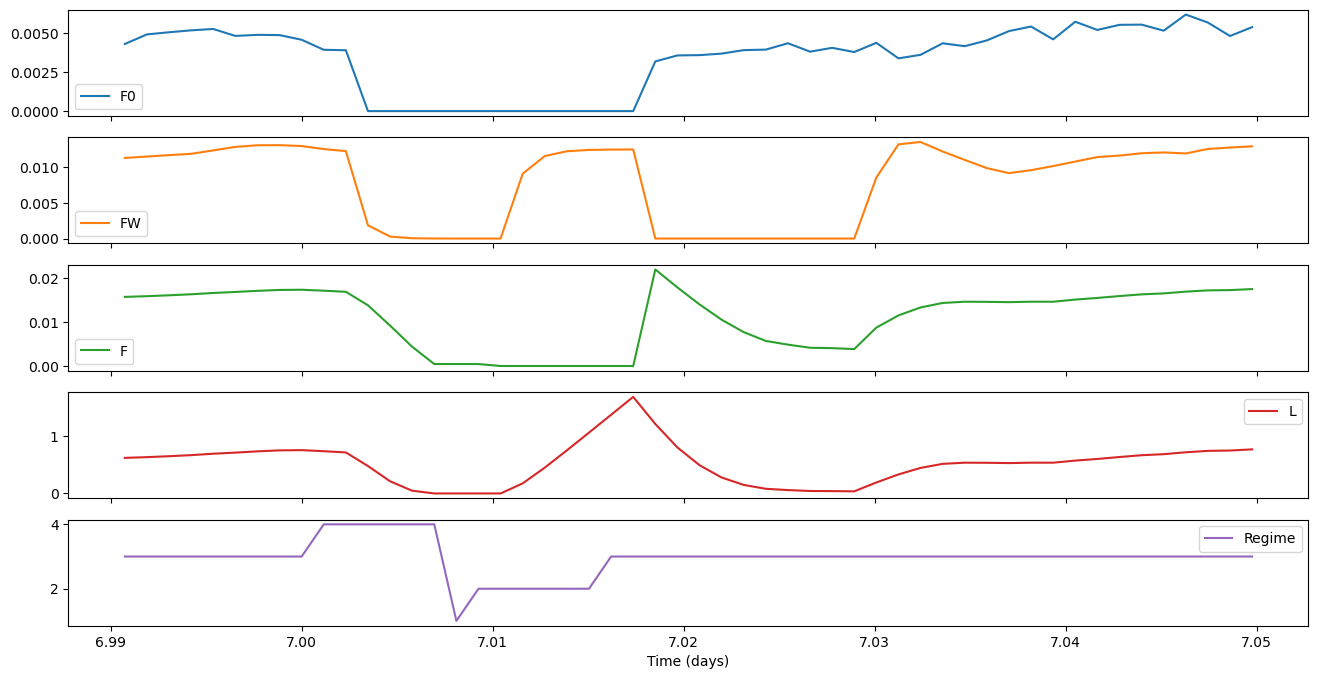

In [30]:
# Plot
startInd = 6.99
endInd = 7.05
plot_list = ['F0','FW','F','L','Regime']
df[plot_list].loc[startInd:endInd].plot(subplots=True, figsize=(16,8))